# Setup, run once

In [1]:
import sys, os
sys.path.append('/.')
import numpy as np
import importlib
import pandas as pd
from io import StringIO # not needed
import re # not needed
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.optimize import minimize
import scipy
import Fiteft


In [37]:
def calculate_likelihood(exp_name, Npoint = 10, devide = False, save_name = 'fit_linear'):
    a = Fiteft.fiteft(experiment=exp_name)
    bigls = []
    # Npoint = 20
    for likelihood_type in ['variable gaussian 0','variable gaussian 1','normal gaussian']:
        # Set attribute for likelihood function
        a.attribute.update({'likelihood_type' : likelihood_type, 'devide' : devide})
        # Find starting point at the minimum (shared over all coefficients)
        res = minimize(lambda x: a.l(x.reshape(1,-1))[0,0,0] , np.zeros(a.Ndf2.shape[1]), jac = lambda x :a.dl(x.reshape(1,-1),)[0,0], method='BFGS', options ={'gtol':1e-3})
        # Loop over coeffients list (fiteft.C2)
        for Ni,name in enumerate(a.C2):
            ls =[]
            # Set up scanning points
            cs = np.linspace(res.x[Ni] -5* res.hess_inv[Ni,Ni]**0.5,res.x[Ni] + 5 * res.hess_inv[Ni,Ni]**0.5, Npoint)
            # Scan to the right of the minimun, then scan to the left of the minimum
            for vals in [cs[(Npoint//2)::1],cs[(Npoint//2)::-1]]:
                # Set up starting point for the nuisance parameters
                temp = np.delete(res.x.copy(), Ni)
                for val in vals:
                    # Find minimum for the nuisance parameters
                    res2 = minimize(lambda x: a.l_profile(x.reshape(1,-1), loc=Ni, val=val,)[0,0,0], temp, jac = lambda x: a.dl_profile(x.reshape(1,-1), loc=Ni,val=val)[0,0], method='BFGS', options ={'gtol':1e-3})
                    ls.append([likelihood_type, name,val,res2.fun])
                    temp = res2.x.copy()
                ls = ls[::-1]
                bigls.append(ls)
    df = pd.DataFrame(np.concatenate(np.array(bigls), axis=0), columns = ['likelihood_type','name','val','L'])
    df[['val','L']] = df[['val','L']].astype(float)
    df.to_csv(f'validation/{exp_name}/{save_name}.csv')
    return df

# ATLAS-CONF-2020-053

## calculate profile likelihood

In [12]:
exp_name = 'ATLAS-CONF-2020-053'
calculate_likelihood(exp_name)

Your input to the likelihood function is a DataFrame with at least one of these colums:
['c(3)Hq', 'c[1]HW-HB-HWB-HDD-uW-uB', 'c[2]HW-HB-HWB-HDD-uW-uB', 'c[3]HW-HB-HWB-HDD-uW-uB', 'c[1]Hu-Hd-Hq(1)', 'c[1]Hl(1)-He', 'c[1]Hl(3)-ll0', 'c[1]HG-uG-uH-top', 'c[2]HG-uG-uH-top', 'c[3]HG-uG-uH-top']


## plot profile likelihood

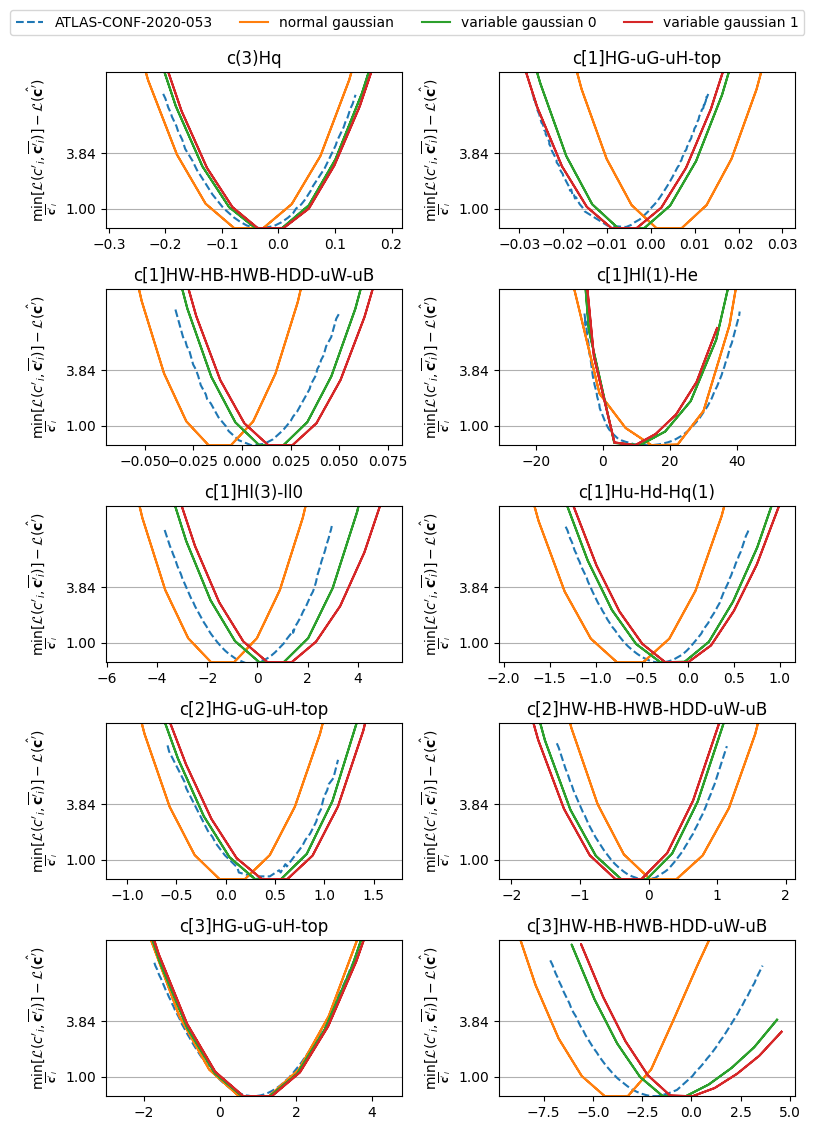

In [47]:
exp_name = 'ATLAS-CONF-2020-053'
df= pd.read_csv(f'validation/{exp_name}/fit_linear.csv', index_col = [0])
fig, axes = plt.subplots(nrows = 5,ncols=2, figsize=(8, 11))
count=0
for name,group in df.groupby('name'):
  ax = axes.flatten()[count]
  count+=1
  temp = pd.read_csv(f'validation/{exp_name}/validation_data/{name}.csv', header=0).sort_values('x', axis=0)
  ax.plot(temp['x'],temp[' y'],'--', label=f'{exp_name}')
  for name2, group2 in group.groupby('likelihood_type'):
    ax.plot(group2['val'],group2['L'] - group2['L'].min(), label=name2)
  ax.set_ylabel("$\min_{\overline{\\mathbf{c}'}_i}[\mathcal{L}(c'_i,\overline{\\mathbf{c}'}_i)] - \mathcal{L}(\hat{\\mathbf{c}'})$")
  ax.set_title(name)
  ax.set_yticks([1,3.84], minor=False)
  ax.yaxis.grid(True, which='major')
  ax.set_ylim(0,8)
  handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,loc=(0.5,0.5),bbox_to_anchor=(0.0, 1.0), ncol=4)
fig.tight_layout()
plt.savefig(f'validation/{exp_name}/fit_linear.pdf',bbox_inches='tight')
plt.savefig(f'validation/{exp_name}/fit_linear.png',bbox_inches='tight')

# ATLAS-CONF-2021-053

## calculate profile likelihood

In [16]:
exp_name = 'ATLAS-CONF-2021-053'
calculate_likelihood(exp_name)

Your input to the likelihood function is a DataFrame with at least one of these colums:
['c(3)Hq', 'cdH', 'ceH', 'c[1]Hl(1)-He', 'c[1]Hl(3)-ll0', 'c[1]Hu-Hd-Hq(1)', 'c[2]Hu-Hd-Hq(1)', 'c[1]HW-HB-HWB-HDD-uW-uB-W', 'c[2]HW-HB-HWB-HDD-uW-uB-W', 'c[3]HW-HB-HWB-HDD-uW-uB-W', 'c[1]HG-uG-uH', 'c[2]HG-uG-uH', 'c[1]top']


## plot profile likelihood

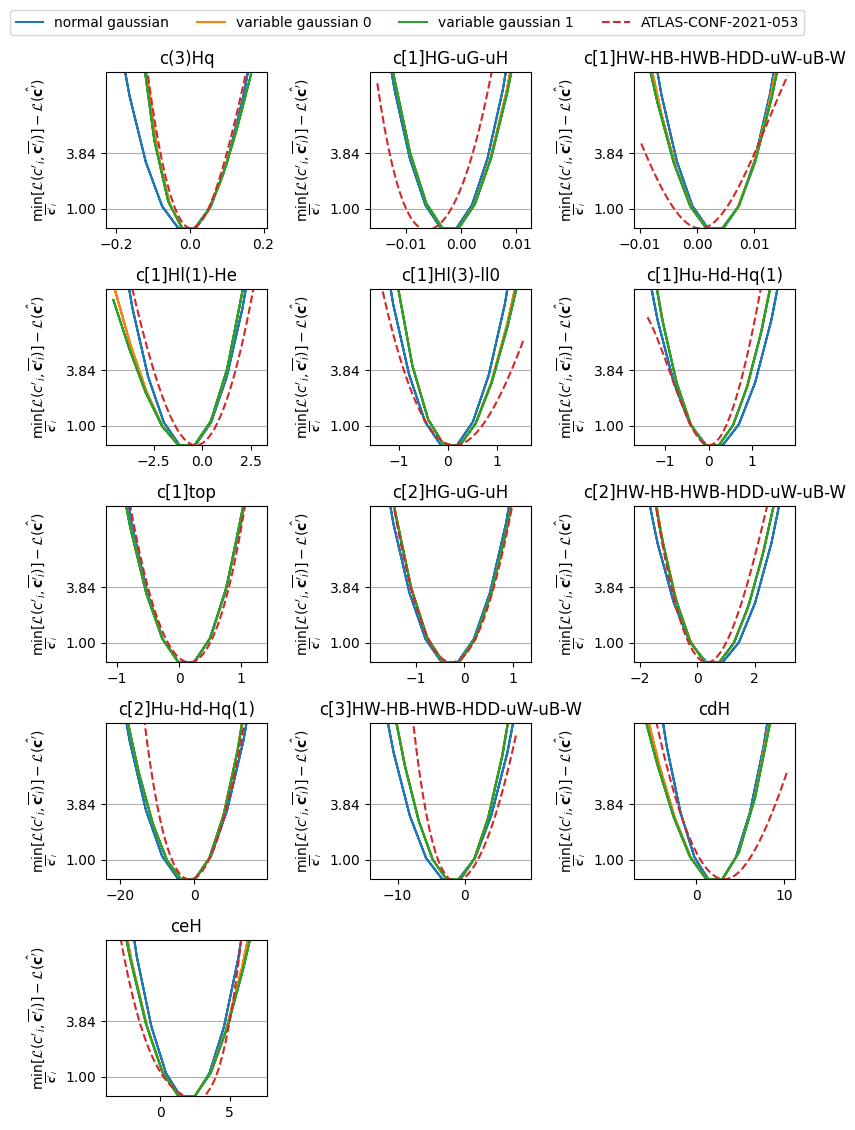

In [46]:
exp_name = 'ATLAS-CONF-2021-053'
df= pd.read_csv(f'validation/{exp_name}/fit_linear.csv', index_col = [0])
fig, axes = plt.subplots(nrows = 5,ncols=3, figsize=(8, 11))
exp_df = pd.read_csv(f'validation/{exp_name}/validation_data/2021-053.csv', index_col=0)[['-95ci','-68ci','center','68ci','95ci']]
count=0
for name,group in df.groupby('name'):
  ax = axes.flatten()[count]
  spline = scipy.interpolate.CubicSpline(exp_df.loc[name],[3.84,1,0,1,3.84], extrapolate=True)
  count+=1
  # ax.plot(temp['x'],temp[' y'],'--', label='ATLAS-CONF-2020-053')
  for name2, group2 in group.groupby('likelihood_type'):
    ax.plot(group2['val'],group2['L'] - group2['L'].min(), label=name2)
  ax.plot(np.linspace(group2['val'].min(),group2['val'].max(),40), spline(np.linspace(group2['val'].min(),group2['val'].max(),40)), '--', label =f'{exp_name}')
  ax.set_ylabel("$\min_{\overline{\\mathbf{c}'}_i}[\mathcal{L}(c'_i,\overline{\\mathbf{c}'}_i)] - \mathcal{L}(\hat{\\mathbf{c}'})$")
  ax.set_title(name)
  ax.set_yticks([1,3.84], minor=False)
  ax.yaxis.grid(True, which='major')
  ax.set_ylim(0,8)
  handles, labels = ax.get_legend_handles_labels()
fig.delaxes(axes[-1,-1])
fig.delaxes(axes[-1,-2])
fig.legend(handles, labels,loc=(0.5,0.5),bbox_to_anchor=(0.0, 1.0), ncol=4)
fig.tight_layout()
plt.savefig(f'validation/{exp_name}/fit_linear.pdf',bbox_inches='tight')
plt.savefig(f'validation/{exp_name}/fit_linear.png',bbox_inches='tight')

# HIGG-2022-17

## linear parametrization

### calculate likelihood

In [34]:
exp_name = 'HIGG-2022-17'
calculate_likelihood(exp_name)

Your input to the likelihood function is a DataFrame with at least one of these colums:
['ceH,22', 'ceH,33', 'c(3)Hq', 'cbH', 'e[1]ggF', 'e[2]ggF', 'e[3]ggF', 'e[1]Hgaga,Zga', 'e[2]Hgaga,Zga', 'e[3]Hgaga,Zga', 'e[1]ZH', 'e[2]ZH', 'e[3]ZH', 'e[4]ZH', 'e[1]ttH', 'e[2]ttH', 'e[3]ttH', 'e[1]glob', 'e[1]Hllll']


,likelihood_type,name,val,L
0,variable gaussian 0,"ceH,22",0.010198,50.637085
1,variable gaussian 0,"ceH,22",0.007826,45.453992
2,variable gaussian 0,"ceH,22",0.005455,41.619999
3,variable gaussian 0,"ceH,22",0.003084,39.097529
4,variable gaussian 0,"ceH,22",0.000713,37.851737
...,...,...,...,...
1249,normal gaussian,e[1]Hllll,0.273862,36.531332
1250,normal gaussian,e[1]Hllll,1.272701,37.818833
1251,normal gaussian,e[1]Hllll,2.271540,40.393841
1252,normal gaussian,e[1]Hllll,3.270378,44.256344


### plot profile likelihood

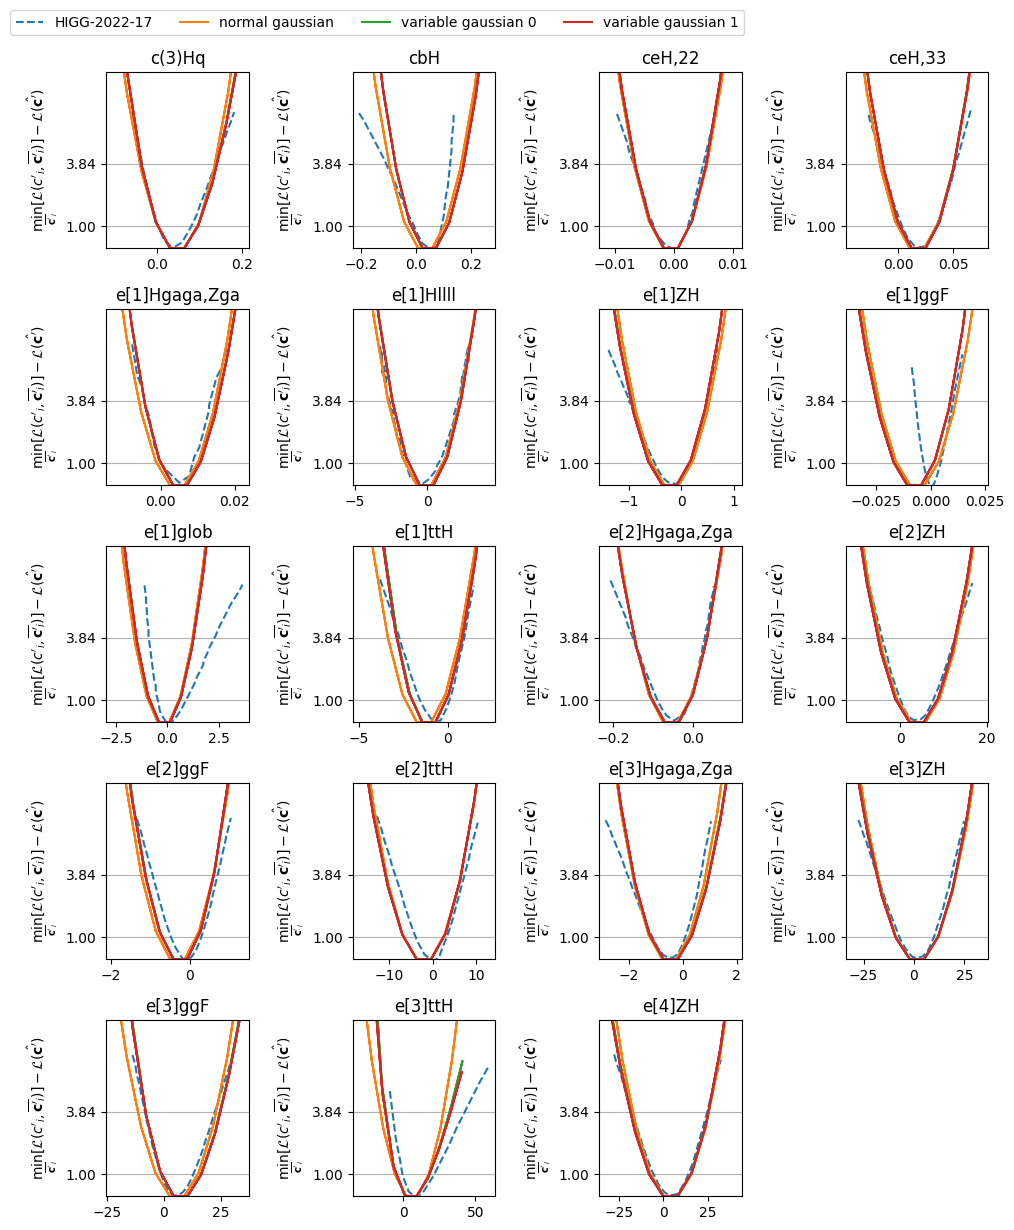

In [44]:
df= pd.read_csv(f'validation/{exp_name}/fit_linear.csv', index_col = [0])
fig, axes = plt.subplots(nrows = 5,ncols=4, figsize=(10, 12))
count=0
for name,group in df.groupby('name'):
  ax = axes.flatten()[count]
  count+=1
  temp = pd.read_csv(f'validation/{exp_name}/validation_data/{name}.csv', header=0).sort_values('x', axis=0)
  ax.plot(temp['x'],temp[' y'],'--', label=f'{exp_name}')
  for name2, group2 in group.groupby('likelihood_type'):
    ax.plot(group2['val'],group2['L'] - group2['L'].min(), label=name2)
  ax.set_ylabel("$\min_{\overline{\\mathbf{c}'}_i}[\mathcal{L}(c'_i,\overline{\\mathbf{c}'}_i)] - \mathcal{L}(\hat{\\mathbf{c}'})$")
  ax.set_title(name)
  ax.set_yticks([1,3.84], minor=False)
  ax.yaxis.grid(True, which='major')
  ax.set_ylim(0,8)
  handles, labels = ax.get_legend_handles_labels()
fig.delaxes(axes[-1,-1])
fig.legend(handles, labels,loc=(0.5,0.5),bbox_to_anchor=(0.0, 1.0), ncol=4)
fig.tight_layout()
plt.savefig(f'validation/{exp_name}/fit_linear.pdf',bbox_inches='tight')
plt.savefig(f'validation/{exp_name}/fit_linear.png',bbox_inches='tight')

## non-linear parametrization

### calculate profile likelihood

In [40]:
exp_name = 'HIGG-2022-17'
calculate_likelihood(exp_name, devide = True, save_name = 'fit_non-linear')

Your input to the likelihood function is a DataFrame with at least one of these colums:
['ceH,22', 'ceH,33', 'c(3)Hq', 'cbH', 'e[1]ggF', 'e[2]ggF', 'e[3]ggF', 'e[1]Hgaga,Zga', 'e[2]Hgaga,Zga', 'e[3]Hgaga,Zga', 'e[1]ZH', 'e[2]ZH', 'e[3]ZH', 'e[4]ZH', 'e[1]ttH', 'e[2]ttH', 'e[3]ttH', 'e[1]glob', 'e[1]Hllll']


,likelihood_type,name,val,L
0,variable gaussian 0,"ceH,22",0.010039,48.109510
1,variable gaussian 0,"ceH,22",0.007719,45.372361
2,variable gaussian 0,"ceH,22",0.005399,42.304907
3,variable gaussian 0,"ceH,22",0.003079,39.530909
4,variable gaussian 0,"ceH,22",0.000759,37.904569
...,...,...,...,...
1249,normal gaussian,e[1]Hllll,0.226552,36.518588
1250,normal gaussian,e[1]Hllll,1.076929,37.580870
1251,normal gaussian,e[1]Hllll,1.927306,39.269954
1252,normal gaussian,e[1]Hllll,2.777684,41.123948


### plot profile likelihood

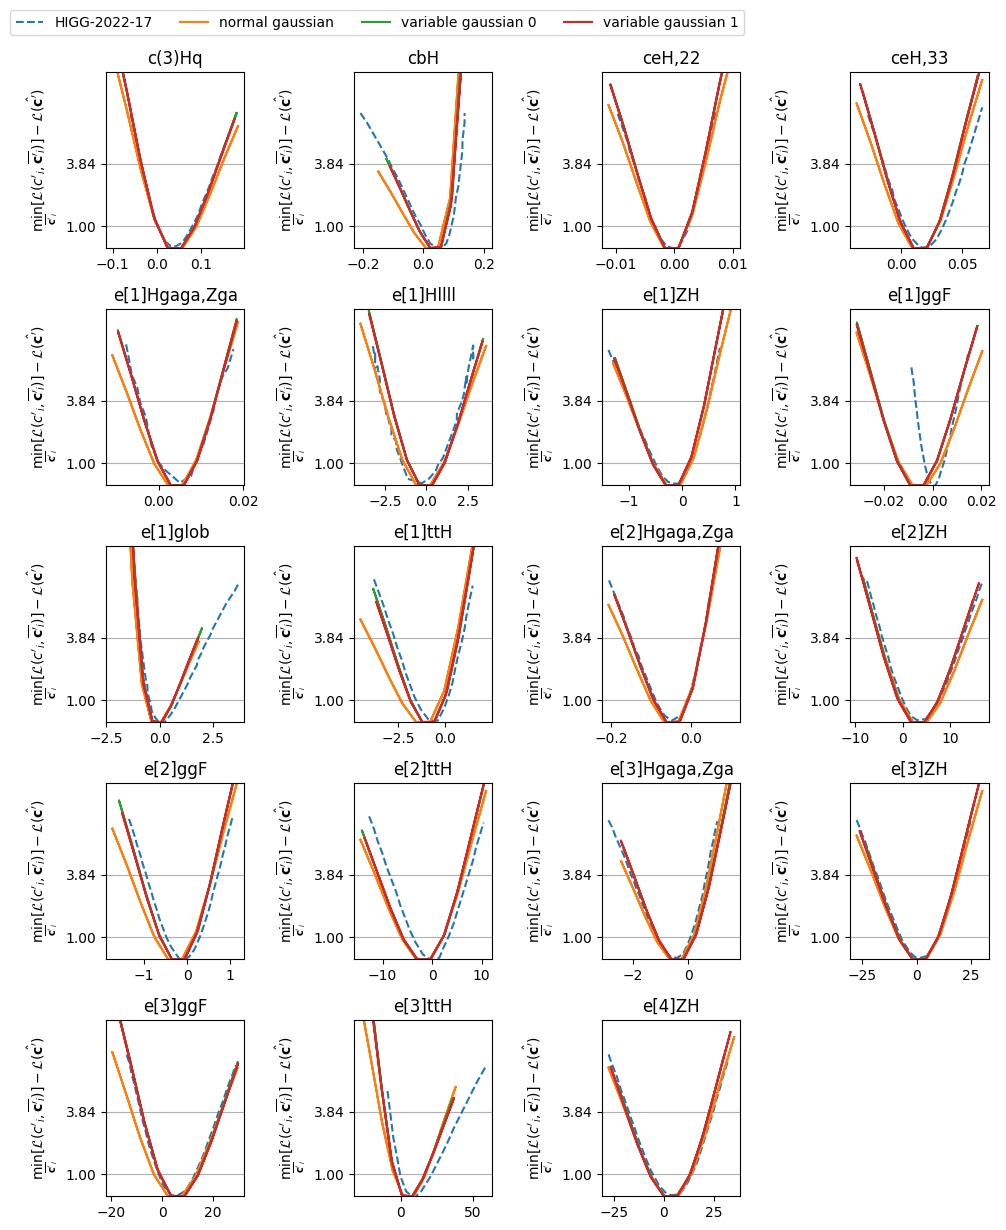

In [43]:
df= pd.read_csv(f'validation/{exp_name}/fit_non-linear.csv', index_col = [0])
fig, axes = plt.subplots(nrows = 5,ncols=4, figsize=(10, 12))
count=0
for name,group in df.groupby('name'):
  ax = axes.flatten()[count]
  count+=1
  temp = pd.read_csv(f'validation/{exp_name}/validation_data/{name}.csv', header=0).sort_values('x', axis=0)
  ax.plot(temp['x'],temp[' y'],'--', label=f'{exp_name}')
  for name2, group2 in group.groupby('likelihood_type'):
    ax.plot(group2['val'],group2['L'] - group2['L'].min(), label=name2)
  ax.set_ylabel("$\min_{\overline{\\mathbf{c}'}_i}[\mathcal{L}(c'_i,\overline{\\mathbf{c}'}_i)] - \mathcal{L}(\hat{\\mathbf{c}'})$")
  ax.set_title(name)
  ax.set_yticks([1,3.84], minor=False)
  ax.yaxis.grid(True, which='major')
  ax.set_ylim(0,8)
  handles, labels = ax.get_legend_handles_labels()
fig.delaxes(axes[-1,-1])
fig.legend(handles, labels,loc=(0.5,0.5),bbox_to_anchor=(0.0, 1.0), ncol=4)
fig.tight_layout()
plt.savefig(f'validation/{exp_name}/fit_non-linear.pdf',bbox_inches='tight')
plt.savefig(f'validation/{exp_name}/fit_non-linear.png',bbox_inches='tight')